# Installs & Imports

In [1]:
!pip install -q lightgbm

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import ks_2samp

import lightgbm as lgb

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Data Loading

In [3]:
def load_data():
    """
    Load the purchase_binary dataset from GitHub.
    Filter the data to include only rows with Promo == 1.
    """
    url = "https://raw.githubusercontent.com/datalev001/RL_GBM/main/data/purchase_binary.csv"
    df = pd.read_csv(url)
    # Filter to use only treatment data (Promo == 1)
    df = df[df["Promo"] == 1].reset_index(drop=True)
    return df

In [4]:
# Run the load_data function
df = load_data()
display(df.head())
print("\nData loaded. Shape:", df.shape)

,Age,Income,Days,Holiday,Channel,Loyalty,Promo,Purchase
0,50,66403.0,14,0,Mobile,4.341803,1,0
1,44,82309.0,4,0,Online,6.518633,1,1
2,51,29895.0,11,1,In-Store,6.348410,1,0
3,60,94792.0,29,0,Online,5.332163,1,1
4,43,66602.0,23,0,Mobile,4.635371,1,1



Data loaded. Shape: (70000, 8)


# Data Preparation

In [5]:
def prepare_data(df):
    """
    Split data into training, validation, and test sets.
    Perform one-hot encoding on the 'Channel' column,
    combine continuous and categorical features, and standardize them.

    Returns:
        X_train, X_val, X_test, y_train, y_val, y_test, features list.
    """
    # First split: 80% train_temp and 20% test
    df_train_temp, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df["Purchase"])
    df_train_temp = df_train_temp.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    # Second split: split train_temp into 75% train and 25% validation
    df_train, df_val = train_test_split(df_train_temp, test_size=0.25, random_state=42, stratify=df_train_temp["Purchase"])
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)

    # Fit OneHotEncoder on the training data for the 'Channel' column
    encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
    encoder.fit(df_train[["Channel"]])
    train_channel_encoded = encoder.transform(df_train[["Channel"]])
    val_channel_encoded = encoder.transform(df_val[["Channel"]])
    test_channel_encoded = encoder.transform(df_test[["Channel"]])
    encoded_feature_names = encoder.get_feature_names_out(["Channel"])

    # Extract continuous features
    X_train_cont = df_train[["Age", "Income", "Days", "Holiday", "Loyalty"]].values.astype(np.float32)
    X_val_cont = df_val[["Age", "Income", "Days", "Holiday", "Loyalty"]].values.astype(np.float32)
    X_test_cont = df_test[["Age", "Income", "Days", "Holiday", "Loyalty"]].values.astype(np.float32)

    # Combine continuous features with the encoded categorical features
    X_train = np.concatenate([X_train_cont, train_channel_encoded], axis=1).astype(np.float32)
    X_val = np.concatenate([X_val_cont, val_channel_encoded], axis=1).astype(np.float32)
    X_test = np.concatenate([X_test_cont, test_channel_encoded], axis=1).astype(np.float32)

    # List of feature names
    features = ["Age", "Income", "Days", "Holiday", "Loyalty"] + list(encoded_feature_names)

    # Extract target arrays
    y_train = df_train["Purchase"].values.astype(np.int64)
    y_val = df_val["Purchase"].values.astype(np.int64)
    y_test = df_test["Purchase"].values.astype(np.int64)

    # Standardize features: fit on training data only
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train).astype(np.float32)
    X_val = scaler.transform(X_val).astype(np.float32)
    X_test = scaler.transform(X_test).astype(np.float32)

    return X_train, X_val, X_test, y_train, y_val, y_test, features

In [6]:
# Run the prepare_data function
X_train, X_val, X_test, y_train, y_val, y_test, features = prepare_data(df)
print(
    "Data prepared. \nTraining samples:", X_train.shape[0],
    "\nValidation samples:", X_val.shape[0],
    "\nTest samples:", X_test.shape[0]
)

Data prepared. 
Training samples: 42000 
Validation samples: 14000 
Test samples: 14000


# Model Training

In [7]:
def train_teacher(X_train, y_train):
    """
    Train a LightGBM classifier on the training data.
    """
    teacher = lgb.LGBMClassifier(random_state=42, verbose=-1)
    teacher.fit(X_train, y_train)
    return teacher

In [8]:
import warnings
warnings.filterwarnings("ignore", message=".*'force_all_finite' was renamed to 'ensure_all_finite'.*")

In [9]:
# Run the train_teacher function
teacher = train_teacher(X_train, y_train)
print("Teacher model trained.")

Teacher model trained.


In [10]:
class LogisticRegressionStudent(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionStudent, self).__init__()
        # The model returns raw logits (no sigmoid in forward)
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x)

In [11]:
def train_student(
    X_train,
    y_train,
    teacher,
    X_val,
    y_val,
    num_epochs=100,
    patience=10,
    batch_size=256,
    temperature=2.0
):
    """
    Train a logistic regression student model using knowledge distillation from the teacher.
    The loss combines:
      - Binary cross-entropy loss (using BCEWithLogitsLoss on raw logits),
      - KL divergence between the softened (temperature-scaled) teacher and student predictions,
      - L1 regularization on the student's weights.
    Early stopping is applied based on the validation loss.

    The teacher's probabilities are converted to logits (via the logit function) and then softened.
    """
    input_dim = X_train.shape[1]
    student = LogisticRegressionStudent(input_dim=input_dim)

    # Prepare training data for PyTorch
    X_train_tensor = torch.from_numpy(X_train)
    y_train_tensor = torch.from_numpy(y_train.reshape(-1, 1)).float()
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Define KL divergence function
    def kl_divergence(p_teacher, p_student, eps=1e-8):
        p_teacher = torch.clamp(p_teacher, eps, 1.0 - eps)
        p_student = torch.clamp(p_student, eps, 1.0 - eps)
        kl = p_teacher * torch.log(p_teacher / p_student) + (1 - p_teacher) * torch.log((1 - p_teacher) / (1 - p_student))
        return torch.mean(kl)

    optimizer = optim.Adam(student.parameters(), lr=0.001)
    bce_loss_fn = nn.BCEWithLogitsLoss()

    # Prepare validation tensors
    X_val_tensor = torch.from_numpy(X_val)
    y_val_tensor = torch.from_numpy(y_val.reshape(-1, 1)).float()

    best_val_loss = float('inf')
    best_epoch = 0
    best_student_state = None

    for epoch in range(num_epochs):
        student.train()
        epoch_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            # Get student raw logits
            student_logits = student(batch_X)  # shape: (batch, 1)

            # Compute standard BCE loss with true labels
            bce_loss = bce_loss_fn(student_logits, batch_y)

            # Get teacher probabilities from the teacher model
            teacher_probs = teacher.predict_proba(batch_X.numpy())[:, 1]  # shape: (batch,)
            # Clamp probabilities to avoid log(0)
            teacher_probs = np.clip(teacher_probs, 1e-8, 1 - 1e-8)
            teacher_probs_tensor = torch.from_numpy(teacher_probs).float().unsqueeze(1)
            # Convert teacher probabilities to logits
            teacher_logits = torch.log(teacher_probs_tensor) - torch.log(1 - teacher_probs_tensor)
            # Compute softened probabilities
            teacher_soft = torch.sigmoid(teacher_logits / temperature)
            student_soft = torch.sigmoid(student_logits / temperature)
            # Compute KL divergence loss and scale by temperature^2
            kl_loss = kl_divergence(teacher_soft, student_soft) * (temperature ** 2)

            # Compute L1 loss on student's weights
            l1_loss = torch.norm(student.linear.weight, 1)

            # Combine losses
            loss = bce_loss + 1.0 * kl_loss + 1e-4 * l1_loss
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_X.size(0)

        epoch_loss /= len(train_dataset)

        # Evaluate on the validation set
        student.eval()
        with torch.no_grad():
            val_logits = student(X_val_tensor)
            val_loss = bce_loss_fn(val_logits, y_val_tensor).item()
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f} - Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            best_student_state = student.state_dict()
        elif epoch - best_epoch >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    if best_student_state is not None:
        student.load_state_dict(best_student_state)

    return student

In [12]:
# Run the train_student function
student = train_student(
    X_train,
    y_train,
    teacher,
    X_val,
    y_val,
    num_epochs=100,
    patience=10,
    batch_size=256,
    temperature=2.0
)
print("\nStudent model trained.")

Epoch 1/100 - Train Loss: 0.9928 - Val Loss: 0.7186
Epoch 2/100 - Train Loss: 0.8519 - Val Loss: 0.6729
Epoch 3/100 - Train Loss: 0.7671 - Val Loss: 0.6444
Epoch 4/100 - Train Loss: 0.7112 - Val Loss: 0.6255
Epoch 5/100 - Train Loss: 0.6725 - Val Loss: 0.6122
Epoch 6/100 - Train Loss: 0.6447 - Val Loss: 0.6030
Epoch 7/100 - Train Loss: 0.6249 - Val Loss: 0.5965
Epoch 8/100 - Train Loss: 0.6107 - Val Loss: 0.5920
Epoch 9/100 - Train Loss: 0.6009 - Val Loss: 0.5890
Epoch 10/100 - Train Loss: 0.5941 - Val Loss: 0.5870
Epoch 11/100 - Train Loss: 0.5896 - Val Loss: 0.5858
Epoch 12/100 - Train Loss: 0.5867 - Val Loss: 0.5851
Epoch 13/100 - Train Loss: 0.5850 - Val Loss: 0.5847
Epoch 14/100 - Train Loss: 0.5839 - Val Loss: 0.5845
Epoch 15/100 - Train Loss: 0.5833 - Val Loss: 0.5844
Epoch 16/100 - Train Loss: 0.5830 - Val Loss: 0.5845
Epoch 17/100 - Train Loss: 0.5829 - Val Loss: 0.5845
Epoch 18/100 - Train Loss: 0.5828 - Val Loss: 0.5845
Epoch 19/100 - Train Loss: 0.5828 - Val Loss: 0.5845
Ep

# Model Evaluation

In [13]:
def evaluate_models(teacher, student, X_test, y_test):
    """
    Evaluate both teacher and student models on the test set.
    Computes AUC, Accuracy, Precision, Recall, F1 Score, and KS statistic.
    Returns a DataFrame with these evaluation metrics.
    """
    # Teacher evaluation
    teacher_test_prob = teacher.predict_proba(X_test)[:, 1]
    teacher_test_pred = teacher.predict(X_test)
    teacher_auc = roc_auc_score(y_test, teacher_test_prob)
    teacher_acc = accuracy_score(y_test, teacher_test_pred)
    teacher_prec = precision_score(y_test, teacher_test_pred, zero_division=0)
    teacher_rec = recall_score(y_test, teacher_test_pred, zero_division=0)
    teacher_f1 = f1_score(y_test, teacher_test_pred, zero_division=0)
    teacher_ks = ks_2samp(teacher_test_prob[y_test == 1], teacher_test_prob[y_test == 0]).statistic

    # Student evaluation
    student.eval()
    with torch.no_grad():
        X_test_tensor = torch.from_numpy(X_test)
        student_logits = student(X_test_tensor)
        # Convert logits to probabilities
        student_test_prob = torch.sigmoid(student_logits).cpu().numpy().flatten()
    student_test_pred = (student_test_prob >= 0.5).astype(int)
    student_auc = roc_auc_score(y_test, student_test_prob)
    student_acc = accuracy_score(y_test, student_test_pred)
    student_prec = precision_score(y_test, student_test_pred, zero_division=0)
    student_rec = recall_score(y_test, student_test_pred, zero_division=0)
    student_f1 = f1_score(y_test, student_test_pred, zero_division=0)
    student_ks = ks_2samp(student_test_prob[y_test == 1], student_test_prob[y_test == 0]).statistic

    metrics_df = pd.DataFrame({
        "Model": ["Teacher (LightGBM)", "Student (Logistic Regression)"],
        "AUC": [teacher_auc, student_auc],
        "Accuracy": [teacher_acc, student_acc],
        "Precision": [teacher_prec, student_prec],
        "Recall": [teacher_rec, student_rec],
        "F1": [teacher_f1, student_f1],
        "KS": [teacher_ks, student_ks]
    })
    return metrics_df

In [14]:
# Run the evaluate_models function
metrics_df = evaluate_models(teacher, student, X_test, y_test)
print("Model Evaluation Metrics:")
display(metrics_df)

Model Evaluation Metrics:


,Model,AUC,Accuracy,Precision,Recall,F1,KS
0,Teacher (LightGBM),0.749280,0.686071,0.704735,0.761168,0.731865,0.361744
1,Student (Logistic Regression),0.753424,0.689857,0.705316,0.771193,0.736785,0.373521


In [15]:
def plot_metrics(metrics_df):
    """
    Plot a grouped bar plot comparing evaluation metrics for both models.
    Moves the legend outside the plot and annotates each bar with its value (if > 0).
    """
    models = metrics_df["Model"]
    x = np.arange(len(models))
    width = 0.15

    fig, ax = plt.subplots(figsize=(10, 6))

    # Create bar containers for each metric
    bars = []
    bars.append(ax.bar(x - 2*width, metrics_df["AUC"], width, label="AUC"))
    bars.append(ax.bar(x - width, metrics_df["Accuracy"], width, label="Accuracy"))
    bars.append(ax.bar(x, metrics_df["Precision"], width, label="Precision"))
    bars.append(ax.bar(x + width, metrics_df["Recall"], width, label="Recall"))
    bars.append(ax.bar(x + 2*width, metrics_df["F1"], width, label="F1"))
    bars.append(ax.bar(x + 3*width, metrics_df["KS"], width, label="KS"))

    # Annotate each bar with its height if height > 0
    for container in bars:
        for bar in container:
            height = bar.get_height()
            if height > 0:
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    height,
                    f'{height:.3f}',
                    ha='center',
                    va='bottom',
                    fontsize=8
                )

    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.set_ylabel("Metric Value")
    ax.set_title("Comparison of Model Evaluation Metrics")

    # Place the legend outside the plot area
    ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

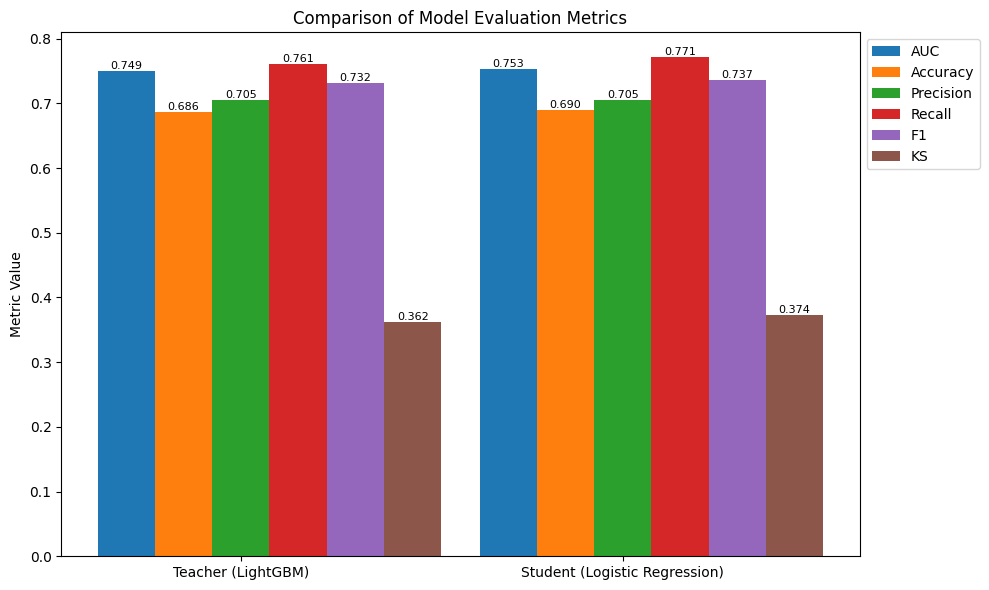

In [16]:
# Run the plot_metrics function
plot_metrics(metrics_df)

# Model Interpretability

In [17]:
def interpret_student(student, features):
    """
    Extract and display the student model's coefficients and bias.
    Ranks features by absolute coefficient value, prints selected features,
    and plots a bar chart of the coefficient values.
    """
    # Extract weights and bias
    weights = student.linear.weight.detach().cpu().numpy().flatten()
    bias = student.linear.bias.detach().cpu().numpy()[0]

    # Pair features with weights and sort by absolute weight (descending)
    feature_importance = list(zip(features, weights))
    feature_importance = sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)

    # Print coefficients and bias
    print("Student Model Coefficients and Feature Importance:")
    print(f"Intercept (bias): {bias:.4f}")
    for feature, coef in feature_importance:
        print(f"Feature: {feature:20s} Coefficient: {coef:.4f}")

    # Determine selected features based on threshold
    threshold = 0.1
    selected_features = [feat for feat, coef in feature_importance if abs(coef) > threshold]
    print("\nFeatures Selected (|coefficient| > 0.1):")
    print(selected_features)

    # Plot coefficient values
    sorted_features, sorted_coefs = zip(*feature_importance)

    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    bars = plt.bar(sorted_features, sorted_coefs, color='skyblue')
    plt.axhline(0, color='black', linewidth=0.8)
    plt.xlabel("Features")
    plt.ylabel("Coefficient Value")
    plt.title("Student Model Coefficients")

    # Annotate each bar with its value
    for bar in bars:
        height = bar.get_height()
        if height >= 0:
            va = 'bottom'
            offset = 3
        else:
            va = 'top'
            offset = -3
        if abs(height) > 0:
            plt.annotate(
                f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, offset),  # vertical offset depending on sign
                textcoords="offset points",
                ha='center',
                va=va,
                fontsize=8
            )

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    print("\n")
    plt.show()

Student Model Coefficients and Feature Importance:
Intercept (bias): 0.3262
Feature: Income               Coefficient: 0.9981
Feature: Age                  Coefficient: 0.3965
Feature: Holiday              Coefficient: 0.2458
Feature: Days                 Coefficient: -0.0761
Feature: Loyalty              Coefficient: -0.0094
Feature: Channel_Online       Coefficient: -0.0037
Feature: Channel_Mobile       Coefficient: -0.0033

Features Selected (|coefficient| > 0.1):
['Income', 'Age', 'Holiday']




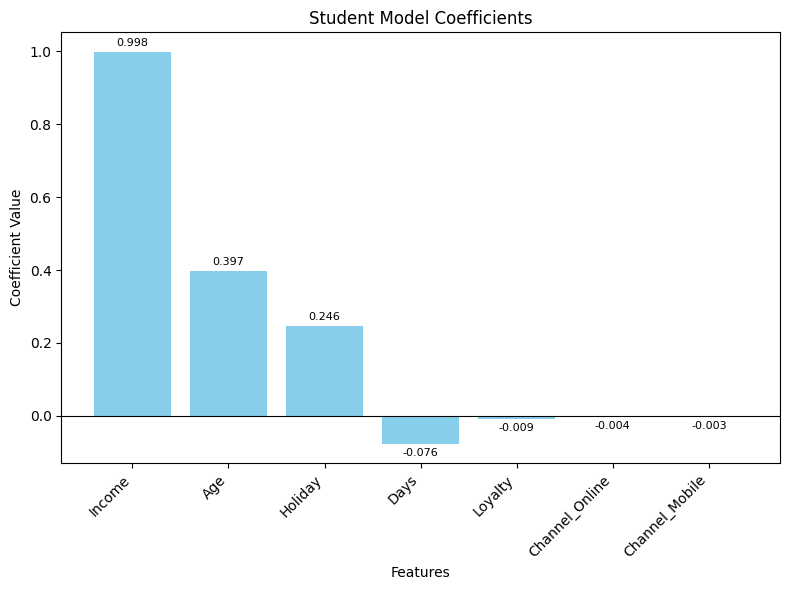

In [18]:
# Run the interpret_student function
interpret_student(student, features)